# Graphs for paper for combinations

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [3]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

In [4]:
import sys
sys.path.append('../')

In [5]:
import neptune

In [6]:
## download from neptune
LOC_START_ID, LOC_END_ID = 1180, 1367
LOC_SKIP_IDS = []
LOC_RUN_IDS = [f"TSDRLOC-{i}" for i in range(LOC_START_ID, LOC_END_ID + 1) if i not in LOC_SKIP_IDS]

In [7]:
def convert_to_dataset_name(target_app: str, middleware: bool, manually_selected: bool) -> str:
    match target_app, middleware, manually_selected:
        case "sock-shop", _, True:
            return "SS-small"
        case "sock-shop", False, False:
            return "SS-medium"
        case "sock-shop", True, False:
            return "SS-large"
        case "train-ticket", _, True:
            return "TT-small"
        case "train-ticket", False, False:
            return "TT-medium"
        case "train-ticket", True, False:
            return "TT-large"
        case _:
            raise ValueError(f"Unknown combination: {target_app}, {middleware}, {manually_selected}")

In [242]:
def fetch_metadata(run_id: str, granularity: str = "cg") -> dict[str, str]:
    with neptune.init_run(
        project="yuuk1/tsdr-localization",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"].fetch() == True:
            return {}

        dataset = run["dataset"].fetch()
        target_app = dataset["target_app"]
        middleware = dataset["metric_types"]["middlewares"]
        manually_selected = dataset["use_manually_selected_metrics"]

        tsdr_params = run["parameters"]["tsdr"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        multi_dist_type = tsdr_params.get("step2_dbscan_dist_type", "")
        
        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (False, False, _, _, _):
                reduction = "None"
            case (True, True, "changepoint", "changepoint-kde", _):
                reduction = "TSifter"
            case (True, False, "zscore_nsigma", _, _):
                reduction = "NSigma"
            case (True, False, "birch_model", _, _):
                reduction = "BIRCH"
            case (True, False, "two_samp_test", _, _):
                reduction = "K-S test"
            case (True, False, "fluxinfer", _, _):
                reduction = "FluxInfer-AD"
            case (False, True, _, "hdbscan", "sbd"):
                reduction = "HDBS-SBD"
            case (False, True, _, "hdbscan", "pearsonr"):
                reduction = "HDBS-R"
            case (_, _, _, _, _):
                assert False, f"Unknown reduction method: {tsdr_params}, RUN_ID: {run_id}"

        # 1. e-Diagnosis
        # 2. RCD
        # 3. CausalRCA+PageRank
        # 4. PC+RW-2
        # 5. GES+RW-2
        # 6. LiNGAM+RW-2
        # 7. PC+PageRank
        # 8. GES+PageRank
        # 9. LiNGAM+PageRank
        # 10. PC+HT
        # 11. GES+HT
        # 12. LiNGAM+HT
        localization: str
        loc_params = run["parameters"].fetch()
        pyrca_method = loc_params.get("method", "")
        walk_method = loc_params.get("walk_method", "")

        if pyrca_method == "epsilon_diagnosis":
            localization = "e-Diagnosis"
        elif loc_params.get("use_rcd", False):
            localization = "RCD"
        elif loc_params.get("use_causalrca", False):
            localization = "CausalRCA"
        elif pyrca_method == "pc" and walk_method == "rw-2":
            localization = "PC+RW-2"
        elif pyrca_method in ["ges", "fges"] and walk_method == "rw-2":
            localization = "GES+RW-2"
        elif pyrca_method == "lingam" and walk_method == "rw-2":
            localization = "LiNGAM+RW-2"
        elif pyrca_method == "call_graph" and walk_method == "rw-2":
            localization = "CG+RW-2"
        elif pyrca_method == "pc" and walk_method == "pagerank":
            localization = "PC+PageRank"
        elif pyrca_method in ["ges", "fges"] and walk_method == "pagerank":
            localization = "GES+PageRank"
        elif pyrca_method == "lingam" and walk_method == "pagerank":
            localization = "LiNGAM+PageRank"
        elif pyrca_method == "call_graph" and walk_method == "pagerank":
            localization = "CG+PageRank"
        elif pyrca_method == "pc" and walk_method == "ht":
            localization = "PC+HT"
        elif pyrca_method in ["ges", "fges"] and walk_method == "ht":
            localization = "GES+HT"
        elif pyrca_method == "lingam" and walk_method == "ht":
            localization = "LiNGAM+HT"
        elif pyrca_method == "call_graph" and walk_method == "ht":
            localization = "CG+HT"
        else:
            assert False, f"Unknown localization method: {loc_params}, RUN_ID: {run_id}"
        
        match granularity:
            case "cg":
                metric = run["scores"]["metric"].fetch()
                ac2 = metric["AC_2_mand"]
                ac5 = metric["AC_5_mand"]
                avg5 = metric["AVG_5_mand"]
                elapsed_time = run["elapsed_time"]["mean"]["elapsed_time"].fetch()
                return {"dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                            "reduction_method": reduction, "localization_method": localization,
                            "ac@2": ac2, "ac@5": ac5, "avg@5": avg5, "elapsed_time": elapsed_time}
            case "fg":
                path = f"/tmp/score-df-by-cause-comp-and-type-{run_id}.html"
                run["eval/score-df-by-cause-comp-and-type"].download(path)
                df = pd.concat(pd.read_html(path), axis=1)
                df.rename(
                    columns={
                        "Unnamed: 0": "dataset_id", "Unnamed: 1": "target_app", "Unnamed: 2": "chaos_comp", "Unnamed: 3": "chaos_type", "Unnamed: 4": "top_k"}, 
                    inplace=True,
                )

                path2 = f"/tmp/elapsed-time-df-by-cause-comp-and-type-{run_id}.html"
                run["elapsed_time/mean_by_chaos_type_and_chaos_comp"].download(path2)
                df2 = pd.concat(pd.read_html(path2), axis=1)
                df2.columns = df2.columns.set_levels(["chaos_type", "chaos_comp", "elapsed_time"], level=0)
                df2.columns = df2.columns.droplevel(1)
                elapsed_times = df2.set_index(["chaos_type", "chaos_comp"]).to_dict()["elapsed_time"]

                items = []
                for name, group in df.groupby(
                    ["dataset_id", "target_app", "chaos_comp", "chaos_type"], as_index=False,
                ):
                    ac_2 = group.loc[group["top_k"] == 2, "AC@K (metric) (mandatory)"].values[0]
                    ac_5 = group.loc[group["top_k"] == 5, "AC@K (metric) (mandatory)"].values[0]
                    avg_5 = group.loc[group["top_k"] == 5, "AVG@K (metric) (mandatory)"].values[0]
                    chaos_type = group["chaos_type"].iat[0]
                    chaos_comp = group["chaos_comp"].iat[0]
                    elapsed_time = elapsed_times[(chaos_type, chaos_comp)] 
                    items.append({
                        "dataset": convert_to_dataset_name(group["target_app"].iat[0], middleware, manually_selected),
                        "reduction_method": reduction, "localization_method": localization,
                        "chaos_comp": chaos_comp, "chaos_type": chaos_type,
                        "ac@2": ac_2, "ac@5": ac_5, "avg@5": avg_5, "elapsed_time": elapsed_time,
                    })
                return items
            case _:
                assert False, f"Unknown granularity: {granularity}"

In [243]:
import joblib

items = joblib.Parallel(n_jobs=64)(joblib.delayed(fetch_metadata)(run, granularity="fg") for run in LOC_RUN_IDS)
assert items is not None
items = [item for item in items if item]
items = sum(items, [])
# assert len(items) <= len(LOC_RUN_IDS), f"{len(items)} > {len(LOC_RUN_IDS)}"

https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1181
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1208
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1190
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1206
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1191
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1188
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1196
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1210
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1203
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1205
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1207
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1182
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1198
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1187
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1183
https://app.neptune.ai/yuuk1/tsdr-localization/e/TSDRLOC-1185
https://

In [244]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    loc_tsdr_df = pd.DataFrame(items)
    display(loc_tsdr_df.groupby(["dataset", "reduction_method", "localization_method"])[["ac@2", "ac@5", "avg@5", "elapsed_time"]].agg("mean"))

ac@2      ac@5     avg@5  \
dataset   reduction_method localization_method                                 
SS-large  BIRCH            CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.136458  0.141667  0.143264   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          FluxInfer-AD     CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.098958  0.146250  0.123590   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          HDBSCAN-R        CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.112500  0.065833  0.103375   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          HDBSCAN-SBD      CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.100000  0.075000  0.093333   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          K-S test         CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.117708  0.144583  0.133049   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          NSigma           CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.097917  0.136667  0.118514   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          None             CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.111458  0.140000  0.126299   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          TSifter          CG+PageRank          0.000000  0.000000  0.000000   
                           RCD                  0.126562  0.128750  0.128302   
                           e-Diagnosis          0.012500  0.007500  0.010042   
SS-medium BIRCH            CG+PageRank          0.006250  0.012500  0.010417   
                           RCD                  0.334375  0.404028  0.356431   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          FluxInfer-AD     CG+PageRank          0.022917  0.016944  0.023458   
                           RCD                  0.355208  0.382083  0.358153   
                           e-Diagnosis          0.000000  0.002500  0.000500   
          HDBSCAN-R        CG+PageRank          0.012500  0.026250  0.013236   
                           RCD                  0.230208  0.195417  0.215194   
                           e-Diagnosis          0.006250  0.023333  0.011750   
          HDBSCAN-SBD      CG+PageRank          0.025000  0.038611  0.029597   
                           RCD                  0.298958  0.229722  0.265667   
                           e-Diagnosis          0.000000  0.020833  0.010833   
          K-S test         CG+PageRank          0.006250  0.017500  0.011833   
                           RCD                  0.305208  0.372361  0.330931   
                           e-Diagnosis          0.000000  0.002500  0.000500   
          NSigma           CG+PageRank          0.034375  0.032917  0.038667   
                           RCD                  0.365625  0.374028  0.361403   
                           e-Diagnosis          0.000000  0.002500  0.000500   
          None             CG+PageRank          0.023958  0.031944  0.030139   
                           RCD                  0.329167  0.398889  0.345333   
                           e-Diagnosis          0.000000  0.000000  0.000000   
          TSifter          CG+PageRank          0.029167  0.054167  0.038750   
                           RCD                  0.387500  0.423333  0.381854   
                           e-Diagnosis          0.060417  0.061458  0.062205   
SS-small  BIRCH            CG+PageRank          0.05

## Load tsdr

In [141]:
TSDR_START_ID, TSDR_END_ID = 793, 840
TSDR_RUN_IDS = [f"TSDR-{id}" for id in range(TSDR_START_ID, TSDR_END_ID + 1)]

In [201]:
def fetch_metadata_of_tsdr(run_id: str, granurality: str = "cg") -> dict[str, str|float]:
    with neptune.init_run(
        project="yuuk1/tsdr",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"] == True:
            return {}
        dataset = run["dataset"].fetch()
        target_app = dataset["target_app"]
        middleware = dataset["metric_types"]["middlewares"]
        manually_selected = dataset["use_manually_selected_metrics"]

        tsdr_params = run["parameters"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        if multi_dist_type := tsdr_params.get("step2_dbscan_dist_type", False):
            multi_dist_type = multi_dist_type
        
        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (False, False, _, _, _):
                reduction = "None"
            case (True, True, "changepoint", "changepoint-kde", _):
                reduction = "TSifter"
            case (True, False, "zscore_nsigma", _, _):
                reduction = "NSigma"
            case (True, False, "birch_model", _, _):
                reduction = "BIRCH"
            case (True, False, "two_samp_test", _, _):
                reduction = "K-S test"
            case (True, False, "fluxinfer", _, _):
                reduction = "FluxInfer-AD"
            case (False, True, _, "hdbscan", "sbd"):
                reduction = "HDBS-SBD"
            case (False, True, _, "hdbscan", "pearsonr"):
                reduction = "HDBS-R"
            case (_, _, _, _, _):
                assert False, f"Unknown reduction method: {tsdr_params}, RUN_ID: {run_id}"

        match granurality:
            case "cg":
                scores = run["scores"].fetch()
                frr = scores["reduction_rate_mean"]
                rfr = scores["cause_metrics"]["recall_mandatory_mean"]
                rfp = scores["cause_metrics"]["proportion_mandatory_mean"]
                num_series = tuple([int (s) for s in scores["num_series"]["total"].split("/")])
                num_found_cause_metrics = scores["cause_metrics"]["num_mandatory_found_mean"]
                elapsed_time = scores["elapsed_time"]
                return {
                    "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                    "reduction_method": reduction,
                    "FRR": frr, "RFR": rfr, "RFP": rfp, "elapsed_time": elapsed_time,
                    "num_metrics(reduced)": num_series[0], "num_metrics(filtered)": num_series[1], "num_metrics(raw)": num_series[2], "num_found_cause_metrics": num_found_cause_metrics,
                    "rs_ac@2": scores["RS_AC_2"], "rs_ac@5": scores["RS_AC_5"], "rs_avg@5": scores["RS_AVG_5"],
                }
            case "fg":
                csv_path = f"/tmp/summary_by_chaos_type_and_chaos_comp-{run_id}.csv"
                df = pd.read_csv(csv_path)
                last_phase = df["phase"].drop_duplicates().sort_values().iat[-1]
                df = df[df["phase"] == last_phase].set_index(["chaos_type", "chaos_comp", "phase"]).sort_index()
                items = []
                for index, row in df.iterrows():
                    frr = row["reduction_rate_mean"]
                    rfr = row["cause_metrics/recall_mandatory_mean"]
                    rfp = row["cause_metrics/proportion_mandatory_mean"]
                    num_series = tuple([int (s) for s in row["num_series/total"].split("/")])
                    num_found_cause_metrics = row["cause_metrics/num_mandatory_found_mean"]
                    elapsed_time = row["elapsed_time"]
                    items.append({
                        "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                        "reduction_method": reduction,
                        "FRR": frr, "RFR": rfr, "RFP": rfp, "elapsed_time": elapsed_time,
                        "num_metrics(reduced)": num_series[0], "num_metrics(filtered)": num_series[1], "num_metrics(raw)": num_series[2], "num_found_cause_metrics": num_found_cause_metrics,
                        "rs_ac@2": row["RS_AC_2"], "rs_ac@5": row["RS_AC_5"], "rs_avg@5": row["RS_AVG_5"],
                        "chaos_type": index[0], "chaos_comp": index[1],
                    })
                return items
            case _:
                assert False, f"Unknown granularity: {granurality}"

In [195]:
tsdr_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_metadata_of_tsdr)(run, granurality="cg") for run in TSDR_RUN_IDS)
assert tsdr_items is not None
tsdr_items = [item for item in tsdr_items if item]
assert len(tsdr_items) <= len(TSDR_RUN_IDS), f"{len(tsdr_items)} > {len(TSDR_RUN_IDS)}"

https://app.neptune.ai/yuuk1/tsdr/e/TSDR-794
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-793
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-796
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-799
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-795
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-797
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-802
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-798
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-800
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-801
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-803
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-804
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-805
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-811
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-809
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-807
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-808
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-806
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-816
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-813
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-810
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-814
https://ap

In [202]:
tsdr_fg_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_metadata_of_tsdr)(run, granurality="fg") for run in TSDR_RUN_IDS)
assert tsdr_fg_items is not None
tsdr_fg_items = [item for item in tsdr_fg_items if item]
tsdr_fg_items = sum(tsdr_fg_items, [])
# assert len(tsdr_items) <= len(TSDR_RUN_IDS), f"{len(tsdr_items)} > {len(TSDR_RUN_IDS)}"

https://app.neptune.ai/yuuk1/tsdr/e/TSDR-793
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-794
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-796
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-798
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-797
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-795
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-802
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-801
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-804
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-800
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-809
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-811
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-806
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-812
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-807
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-799
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-818
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-805
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-803
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-822
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-814
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-813
https://ap

In [144]:
def create_table_dataframe_multi_level(
    items: list[dict[str, str|float]],
    first_levels: list[str], second_levels: list[str], first_level_key: str, second_level_key: str, first_label: str, second_label: str,
    columns: list[str],
) -> pd.DataFrame:
    multi_level_indexes = pd.MultiIndex.from_product(
        [first_levels, second_levels], names=[first_label, second_label])
    multi_level_cols = pd.MultiIndex.from_product([first_levels, columns], names=['', ''])
    df = pd.DataFrame(items).set_index([first_level_key, second_level_key]).reindex(index=multi_level_indexes)
    df = df.unstack(first_label)
    df = df.swaplevel(axis=1).sort_index(axis=1).reindex(
        index=second_levels, columns=multi_level_cols,
    )
    return df

from itertools import product

def to_latex_table(table_df: pd.DataFrame, first_levels: list[str], second_levels: list[str], columns: list[str], highlight_max_columns: list[str], highlight_min_columns: list[str]) -> str:
    styler = table_df[product(first_levels, columns)].style
    styler.highlight_max(subset=(second_levels, list(product(first_levels, highlight_max_columns))), props='textbf:--rwrap;')\
        .highlight_min(subset=(second_levels, list(product(first_levels, highlight_min_columns))), props='textbf:--rwrap;')
    styler.format({k: '{:.4f}' for k in product(first_levels, ["RFP"])}, precision=3)
    return styler.to_latex(hrules=True)

In [150]:
reduction_methods = [
    "None", "NSigma", "BIRCH", "K-S test", "FluxInfer-AD", "HDBSCAN-SBD", "HDBSCAN-R", "TSifter"]
metrics = ["FRR", "RFR", "RFP", "elapsed_time"]
ss_datasets = ["SS-small", "SS-medium", "SS-large"]
tt_datasets = ["TT-small", "TT-medium", "TT-large"]
datasets = ss_datasets + tt_datasets

tsdr_df = pd.DataFrame(tsdr_items)

In [146]:
ss_table_df = create_table_dataframe_multi_level(
    items=tsdr_items,
    first_levels=ss_datasets, second_levels=reduction_methods,
    first_level_key="dataset", second_level_key="reduction_method",
    first_label="Dataset", second_label="Reduction Method",
    columns=metrics,
)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(ss_table_df)

print(
    to_latex_table(ss_table_df, ss_datasets, reduction_methods, metrics, ["FRR", "RFR", "RFP"], ["elapsed_time"])
)

SS-small                                SS-medium            \
                       FRR     RFR       RFP elapsed_time       FRR       RFR   
Reduction Method                                                                
None              0.000000  1.0000  0.015518     0.276380  0.000000  1.000000   
NSigma            0.128410  0.9875  0.017695     0.537260  0.174410  0.987500   
BIRCH             0.156613  1.0000  0.018698     0.353011  0.181778  1.000000   
K-S test          0.130166  1.0000  0.018141     0.558450  0.133890  1.000000   
FluxInfer-AD      0.130166  1.0000  0.018141     0.566260  0.133890  1.000000   
HDBSCAN-SBD       0.458552  0.4250  0.012174     0.615068  0.689923  0.247083   
HDBSCAN-R         0.459161  0.4000  0.011460     0.650790  0.694884  0.234583   
TSifter           0.355634  0.9125  0.023763     0.803499  0.468055  0.920833   

                                         SS-large                      \
                       RFP elapsed_time       FRR       RFR       RFP   
Reduction Method                                                        
None              0.023744     0.293380  0.000000  1.000000  0.004991   
NSigma            0.028192     0.574358  0.316506  0.962538  0.006918   
BIRCH             0.029020     0.394243  0.239872  0.976174  0.006328   
K-S test          0.027427     0.601738  0.118534  0.996875  0.005626   
FluxInfer-AD      0.027427     0.622737  0.118534  0.996875  0.005626   
HDBSCAN-SBD       0.018738     0.705545  0.843256  0.135685  0.003975   
HDBSCAN-R         0.018147     0.944539  0.836142  0.138511  0.003810   
TSifter           0.043231     1.004181  0.554197  0.804521  0.008671   

                               
                 elapsed_time  
Reduction Method               
None                 0.431810  
NSigma               1.082570  
BIRCH                0.905643  
K-S test             1.144316  
FluxInfer-AD         1.150177  
HDBSCAN-SBD          5.701363  
HDBSCAN-R           75.128691  
TSifter              3.054405

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & \multicolumn{4}{r}{SS-small} & \multicolumn{4}{r}{SS-medium} & \multicolumn{4}{r}{SS-large} \\
 & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time \\
Reduction Method &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
None & 0.000 & \textbf{1.000} & 0.0155 & \textbf{0.276} & 0.000 & \textbf{1.000} & 0.0237 & \textbf{0.293} & 0.000 & \textbf{1.000} & 0.0050 & \textbf{0.432} \\
NSigma & 0.128 & 0.988 & 0.0177 & 0.537 & 0.174 & 0.988 & 0.0282 & 0.574 & 0.317 & 0.963 & 0.0069 & 1.083 \\
BIRCH & 0.157 & \textbf{1.000} & 0.0187 & 0.353 & 0.182 & \textbf{1.000} & 0.0290 & 0.394 & 0.240 & 0.976 & 0.0063 & 0.906 \\
K-S test & 0.130 & \textbf{1.000} & 0.0181 & 0.558 & 0.134 & \textbf{1.000} & 0.0274 & 0.602 & 0.119 & 0.997 & 0.0056 & 1.144 \\
FluxInfer-AD & 0.130 & \textbf{1.000} & 0.0181 & 0.566 & 0.134 & \textbf{1.000} & 0.0274 & 0.623 & 0.119 & 0.997 & 0.0056 & 1.150 \\
HDBSCAN-SBD & 0.459 & 0.425 & 0.0122

In [147]:
tt_table_df = create_table_dataframe_multi_level(
    items=tsdr_items,
    first_levels=tt_datasets, second_levels=reduction_methods,
    first_level_key="dataset", second_level_key="reduction_method",
    first_label="Dataset", second_label="Reduction Method",
    columns=metrics,
)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(tt_table_df)

print(
    to_latex_table(tt_table_df, tt_datasets, reduction_methods, metrics, ["FRR", "RFR", "RFP"], ["elapsed_time"])
)

TT-small                                  TT-medium  \
                       FRR       RFR       RFP elapsed_time       FRR   
Reduction Method                                                        
None              0.000000  1.000000  0.003078     0.964681  0.000000   
NSigma            0.289648  1.000000  0.004373     1.996367  0.327328   
BIRCH             0.263016  0.976190  0.004080     1.174450  0.267093   
K-S test          0.274108  1.000000  0.004308     1.918581  0.261482   
FluxInfer-AD      0.274108  1.000000  0.004308     2.063774  0.261482   
HDBSCAN-SBD       0.523989  0.357143  0.002180     2.299064  0.742595   
HDBSCAN-R         0.525968  0.571429  0.003765     2.247726  0.741878   
TSifter           0.567204  0.880952  0.006246     3.196355  0.674851   

                                                   TT-large            \
                       RFR       RFP elapsed_time       FRR       RFR   
Reduction Method                                                        
None              1.000000  0.003429     1.016921  0.000000  1.000000   
NSigma            1.000000  0.005083     2.288860  0.467522  0.997024   
BIRCH             1.000000  0.004661     1.515700  0.353294  1.000000   
K-S test          1.000000  0.004619     2.382055  0.241357  0.996032   
FluxInfer-AD      1.000000  0.004619     2.388426  0.241357  0.996032   
HDBSCAN-SBD       0.173810  0.002493     3.025990  0.854127  0.135629   
HDBSCAN-R         0.173810  0.002491     3.607157  0.845956  0.129110   
TSifter           0.948413  0.010057     4.892048  0.710454  0.722222   

                                         
                       RFP elapsed_time  
Reduction Method                         
None              0.000726     2.041240  
NSigma            0.001365     5.810788  
BIRCH             0.001123     4.871833  
K-S test          0.000956     5.996076  
FluxInfer-AD      0.000956     6.058931  
HDBSCAN-SBD       0.000681    14.628286  
HDBSCAN-R         0.000626    97.571105  
TSifter           0.001788    23.780614

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & \multicolumn{4}{r}{TT-small} & \multicolumn{4}{r}{TT-medium} & \multicolumn{4}{r}{TT-large} \\
 & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time \\
Reduction Method &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
None & 0.000 & \textbf{1.000} & 0.0031 & \textbf{0.965} & 0.000 & \textbf{1.000} & 0.0034 & \textbf{1.017} & 0.000 & \textbf{1.000} & 0.0007 & \textbf{2.041} \\
NSigma & 0.290 & \textbf{1.000} & 0.0044 & 1.996 & 0.327 & \textbf{1.000} & 0.0051 & 2.289 & 0.468 & 0.997 & 0.0014 & 5.811 \\
BIRCH & 0.263 & 0.976 & 0.0041 & 1.174 & 0.267 & \textbf{1.000} & 0.0047 & 1.516 & 0.353 & \textbf{1.000} & 0.0011 & 4.872 \\
K-S test & 0.274 & \textbf{1.000} & 0.0043 & 1.919 & 0.261 & \textbf{1.000} & 0.0046 & 2.382 & 0.241 & 0.996 & 0.0010 & 5.996 \\
FluxInfer-AD & 0.274 & \textbf{1.000} & 0.0043 & 2.064 & 0.261 & \textbf{1.000} & 0.0046 & 2.388 & 0.241 & 0.996 & 0.0010 & 6.059 \\
HDBSCAN-SBD & 0.52

## Join tsdr and localization

In [314]:
import itertools

tsdr_fg_df = pd.DataFrame(tsdr_fg_items) # .set_index(["dataset", "reduction_method", "chaos_type", "chaos_comp"])
loc_rs_df = pd.DataFrame(
    {
        "dataset": row["dataset"], "localization_method": "RS", "reduction_method": row["reduction_method"],
        "ac@2": row["rs_ac@2"], "ac@5": row["rs_ac@5"], "avg@5": row["rs_avg@5"], "chaos_type": row["chaos_type"], "chaos_comp": row["chaos_comp"],
    } for _, row in tsdr_fg_df.iterrows()
)
loc_rs_df

,dataset,localization_method,reduction_method,ac@2,ac@5,avg@5,chaos_type,chaos_comp
0,SS-small,RS,None,0.031201,0.076187,0.046195,pod-cpu-hog,carts
1,SS-small,RS,None,0.030914,0.075503,0.045776,pod-cpu-hog,carts-db
2,SS-small,RS,None,0.031015,0.075742,0.045923,pod-cpu-hog,catalogue
3,SS-small,RS,None,0.031201,0.076187,0.046195,pod-cpu-hog,catalogue-db
4,SS-small,RS,None,0.030728,0.075058,0.045503,pod-cpu-hog,orders
...,...,...,...,...,...,...,...,...
715,TT-large,RS,HDBSCAN-R,0.000924,0.002306,0.001384,pod-memory-hog,ts-order-service
716,TT-large,RS,HDBSCAN-R,0.001328,0.003317,0.001991,pod-memory-hog,ts-station-service
717,TT-large,RS,HDBSCAN-R,0.001340,0.003347,0.002009,pod-memory-hog,ts-train-service
718,TT-large,RS,HDBSCAN-R,0.002871,0.007162,0.004301,pod-memory-hog,ts-travel-service


In [316]:
combined_loc_tsdr_df = pd.concat([loc_tsdr_df, loc_rs_df], axis=0)

joined_df = combined_loc_tsdr_df.set_index(["dataset", "localization_method"]).join(
    tsdr_fg_df.set_index(["dataset", "reduction_method", "chaos_type", "chaos_comp"]), how="outer", on=['dataset', 'reduction_method', 'chaos_type', 'chaos_comp'],
    lsuffix='_loc', rsuffix='_tsdr',
)
joined_df["elapsed_time_sum"] = joined_df["elapsed_time_loc"] + joined_df["elapsed_time_tsdr"]
# with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.float_format", lambda x: f"{x:.4f}"):
display(
   joined_df.reset_index().set_index(['dataset', 'localization_method', 'reduction_method']).sort_index()
)

chaos_comp  \
dataset  localization_method reduction_method                       
SS-large CG+PageRank         BIRCH                          carts   
                             BIRCH                          carts   
                             BIRCH                       carts-db   
                             BIRCH                       carts-db   
                             BIRCH                      catalogue   
...                                                           ...   
TT-small e-Diagnosis         TSifter           ts-station-service   
                             TSifter           ts-station-service   
                             TSifter             ts-train-service   
                             TSifter             ts-train-service   
                             TSifter              ts-user-service   

                                                   chaos_type  ac@2  ac@5  \
dataset  localization_method reduction_method                               
SS-large CG+PageRank         BIRCH                pod-cpu-hog   0.0   0.0   
                             BIRCH             pod-memory-hog   0.0   0.0   
                             BIRCH                pod-cpu-hog   0.0   0.0   
                             BIRCH             pod-memory-hog   0.0   0.0   
                             BIRCH                pod-cpu-hog   0.0   0.0   
...                                                       ...   ...   ...   
TT-small e-Diagnosis         TSifter              pod-cpu-hog   0.0   0.0   
                             TSifter           pod-memory-hog   0.0   0.1   
                             TSifter              pod-cpu-hog   0.0   0.0   
                             TSifter           pod-memory-hog   0.0   0.0   
                             TSifter              pod-cpu-hog   0.0   0.0   

                                               avg@5  elapsed_time_loc  \
dataset  localization_method reduction_method                            
SS-large CG+PageRank         BIRCH             0.000          9.972529   
                             BIRCH             0.000         11.308958   
                             BIRCH             0.000         13.559471   
                             BIRCH             0.000         12.477268   
                             BIRCH             0.000         10.769680   
...                                              ...               ...   
TT-small e-Diagnosis         TSifter           0.000          6.549011   
                             TSifter           0.045          8.113077   
                             TSifter           0.000          3.833191   
                             TSifter           0.000          7.515868   
                             TSifter           0.000          6.151402   

                                                    FRR       RFR       RFP  \
dataset  localization_method reduction_method                                 
SS-large CG+PageRank         BIRCH             0.272192  0.966667  0.004851   
                             BIRCH             0.260358  1.000000  0.008183   
                             BIRCH             0.228505  1.000000  0.007624   
                             BIRCH             0.255093  0.818182  0.008929   
                             BIRCH             0.260120  1.000000  0.003106   
...                                                 ...       ...       ...   
TT-small e-Diagnosis         TSifter           0.601739  0.666667  0.004422   
                             TSifter           0.466685  1.000000  0.005225   
                             TSifter           0.701429  1.000000  0.010625   
                             TSifter           0.498814  1.000000  0.006117   
                             TSifter           0.603672  1.000000  0.008502   

                                               elapsed_time_tsdr  \
dataset  localization_method reduction_method                      
SS-large CG+PageRank        

In [407]:
import seaborn as sns
from itertools import cycle


LOC_METHODS = ["RS", "e-Diagnosis", "CG+PageRank", "PC+PageRank", "LiNGAM+PageRank", "PC+HT", "LiNGAM+HT", "RCD"]
LOC_METHODS_COMMON = ["RS", "e-Diagnosis", "CG+PageRank", "RCD"]

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.3)
sns.set_palette("tab10", 8, 0.5)

def wrap(label: str):
    match label.get_text():
        case "FluxInfer-AD":
            return "FluxInfer-\nAD"
        case "HDBSCAN-SBD":
            return "HDBS-SBD"
        case "HDBSCAN-R":
            return "HDBS-R"
    return label


def plot_combination(dataset: str, evaluation_metric: str, ylabel: str, loc_methods: list[str], plot_type: str = "bar"):
    data = joined_df.reset_index().query(f"dataset == '{dataset}' and localization_method != 'CausalRCA'")
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    match plot_type:
        case "bar":
            # bar = sns.barplot(
            #     data=data, x="reduction_method", y=evaluation_metric, hue="localization_method",
            #     order=reduction_methods, hue_order=loc_methods, dodge=True,
            #     color="none", fill=None,
            #     ax=ax,
            # )
            sns_fig = sns.boxplot(
                data=data, x="reduction_method", y=evaluation_metric, hue="localization_method",
                order=reduction_methods, hue_order=loc_methods, dodge=True,
                showfliers=False, showmeans=False, ax=ax,
            )
            # pallette = cycle(sns.color_palette(n_colors=len(loc_methods)))
            hatchs = ["++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****"][0:len(loc_methods)]
            for i, (patch, hatch) in enumerate(zip(
                [p for p in sns_fig.patches if not p.get_label()],
                cycle(hatchs),
            )):
                patch.set_hatch(hatch)
                fc = patch.get_facecolor()
                patch.set_edgecolor(fc)
                patch.set_facecolor('none')
                for j in range(5*i,5*(i+1)):
                    sns_fig.lines[j].set_color(fc)

        case "point":
            markers = ["o", "s", "D", "v", "^", "P", "X", "p", "d"][0:len(loc_methods)]
            linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"][0:len(loc_methods)]
            sns_fig = sns.pointplot(
                data=data, x="reduction_method", y=evaluation_metric, hue="localization_method",
                order=reduction_methods, hue_order=loc_methods,
                dodge=True, markers=markers, linestyles=linestyles, scale=0.8,
                ax=ax,
            )

    ax.set_xlabel("Reduction Method")
    ax.set_ylabel(ylabel)
    ax.set_xticklabels([wrap(l) for l in ax.get_xticklabels()], rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.legend(title="Localization Method")

    if plot_type == "bar":
        # https://stackoverflow.com/questions/72656861/how-to-add-hatches-to-boxplots-with-sns-boxplot-or-sns-catplot
        l = sns_fig.legend()
        for lp, hatch in zip(l.get_patches(), hatchs):
            lp.set_hatch(hatch)
            fc = lp.get_facecolor()
            lp.set_edgecolor(fc)
            lp.set_facecolor('none')
            
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=4, title="Localization Method", frameon=False,
    )

    fig.savefig(f"materials/plot_combination_{dataset}_{evaluation_metric}.pdf", format="pdf", bbox_inches="tight")


def plot_combination_with_two_ylabels(dataset: str, loc_methods: list[str]):
    data = joined_df.reset_index().query(f"dataset == @dataset and localization_method in @loc_methods")

    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    ax2 = ax.twinx()
    sns.barplot(
        data=data, x="reduction_method", y="ac@5", hue="localization_method",
        order=reduction_methods, hue_order=loc_methods, dodge=True,
        ax=ax,
    )
    sns.pointplot(
        data=data, x="reduction_method", y="elapsed_time_loc", hue="localization_method",
        order=reduction_methods, hue_order=loc_methods, dodge=True,
        ax=ax2,
    )

    ax.set_xlabel("Reduction Method")
    ax.set_ylabel("AC@5")
    ax2.set_ylabel("T(s)")
    ax.set_xticklabels([wrap(l) for l in ax.get_xticklabels()], rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.legend(title="Localization Method")
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=4, title="Localization Method", frameon=False,
    )
    fig.savefig(f"materials/plot_combination_with_2labels_{dataset}.pdf", format="pdf", bbox_inches="tight")


# def plot_localization_perf_by_loc_method(loc_method: str):
#     data = joined_df.reset_index().query("localization_method == @loc_method")

#     fig, ax1 = plt.subplots(1, 1, figsize=(9, 5))
#     ax2 = ax1.twinx()
#     sns.barplot(
#         data=data, x="reduction_method", y="ac@5", hue="dataset",
#         order=reduction_methods, hue_order=datasets, dodge=True,
#         ax=ax1,
#     )
#     sns.pointplot(
#         data=data, x="reduction_method", y="elapsed_time_loc", hue="dataset",
#         order=reduction_methods, hue_order=datasets, dodge=.8 - .8 / 3,
#         ax=ax2,
#     )

#     ax1.set_xlabel("Reduction Method", fontsize=12)
#     ax1.set_ylabel("AC@5", fontsize=12)
#     ax1.set_xticklabels([wrap(l) for l in ax1.get_xticklabels()], rotation=0, fontsize=10)
#     ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=10)

#     max1 = np.nanmax(np.abs(ax1.get_ybound())) 
#     max2 = np.nanmax(np.abs(ax2.get_ybound()))
#     nticks = 7 
#     ax2.set_ylabel("T(s)", fontsize=12)
#     ax2.get_legend().remove()

#     ax1.legend(title="Dataset")
#     sns.move_legend(
#         ax1, "lower center",
#         bbox_to_anchor=(.5, 1), ncol=6, title="Dataset", frameon=False, fontsize=10, title_fontsize=12,
#     )
#     fig.savefig(f"materials/plot_localization_perf_by_loc_method_{loc_method}.pdf", format="pdf", bbox_inches="tight")

def style_boxplot(sns_fig, hatchs):
    # see https://gist.github.com/mourisl/30d9a8e130f80bde382f95b8ccb3f59d
    for i, (box, hatch) in enumerate(zip([p for p in sns_fig.patches if not p.get_label()], hatchs)): 
        color = box.get_facecolor()
        box.set_edgecolor(color)
        box.set_facecolor((0, 0, 0, 0))
        box.set_hatch(hatch)
        # iterate over whiskers and median lines
        for j in range(5*i,5*(i+1)):
            sns_fig.lines[j].set_color(color)


def facetgrid_two_axes(data: pd.DataFrame, x_name: str, y1_name: str, y2_name: str, ylabel1: str, ylabel2: str, order: list[str], color: str, label: str):
    ax1 = plt.gca()
    # bar = sns.barplot(data, x=x_name, y=y1_name, alpha=.7, ax=ax1, order=order, color="none", fill=None)
    sns_fig = sns.boxplot(
        data, x=x_name, y=y1_name, ax=ax1, order=order,
        color="none", notch=False, showfliers=False, showcaps=True,
    )
    ax1.grid(False)
    ax1.set_ylabel(ylabel1)
    ax1.set_xticks(np.arange(len(ax1.get_xticklabels())))
    ax1.set_xticklabels([wrap(l) for l in ax1.get_xticklabels()], rotation=-90)
    ax1.autoscale(enable=True, axis='y', tight=False)
    ax1.ticklabel_format(style="sci", axis="y", scilimits=(-2,2))

    hatchs = ["++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****"]
    style_boxplot(sns_fig, hatchs)
    # for _bar, hatch in zip(sns_fig.patches, hatchs):
    #     _bar.set_hatch(hatch)
    #     _bar.set_edgecolor(color)

    if data["localization_method"].apply(lambda x: x == "RS").all():
        return

    ax2 = ax1.twinx()
    sns.pointplot(data, x=x_name, y=y2_name, ax=ax2, order=order)
    ax2.grid(False)
    ax2.set_ylabel(ylabel2)
    ax2.autoscale(enable=True, axis='y', tight=False)
    ax2.ticklabel_format(style="sci", axis="y", scilimits=(-2,2))

import matplotlib

def plot_grid(datasets: list[str], loc_methods: list[str], col: str, row: str):
    data = joined_df.reset_index().query("dataset in @datasets and localization_method in @loc_methods")
    match (col, row):
        case "dataset", "localization_method":
            row_order = loc_methods
            col_order = datasets
            map_x = "reduction_method"
            map_x_order = reduction_methods
        case "localization_method", "dataset":
            row_order = datasets
            col_order = loc_methods
            map_x = "reduction_method"
            map_x_order = reduction_methods
        case "dataset", "reduction_method":
            row_order = reduction_methods
            col_order = datasets
            map_x = "localization_method"
            map_x_order = loc_methods
        case "reduction_method", "dataset":
            row_order = datasets
            col_order = reduction_methods
            map_x = "localization_method"
            map_x_order = loc_methods
        case _:
            raise ValueError(f"Unknown combination: {col}, {row}")

    g = sns.FacetGrid(
        data, col=col, row=row, height=2.5, aspect=1.3, col_order=col_order, margin_titles=True, despine=False, row_order=row_order,
        sharex=True, sharey=False,
    )
    g.set_titles(row_template='{row_name}', col_template='{col_var}: {col_name}', size=12)
    g.map_dataframe(
        facetgrid_two_axes, x_name=map_x, y1_name="avg@5", y2_name="elapsed_time_loc", ylabel1='AVG@5', ylabel2='T(s)', order=map_x_order, label="",
    )
    for ax in g.axes.flat:
        for text in ax.texts:
            if isinstance(text, matplotlib.text.Annotation):
                # adjust the position of the row text
                text.set_x(text.get_position()[0] + 0.4)
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.tight_layout()
    g.savefig(f"materials/plot_reduction_and_localization_grid_{col}_and_{row}.pdf", format="pdf", bbox_inches="tight")

In [326]:
plt.figure().clear()
plt.clf()
plt.close()

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


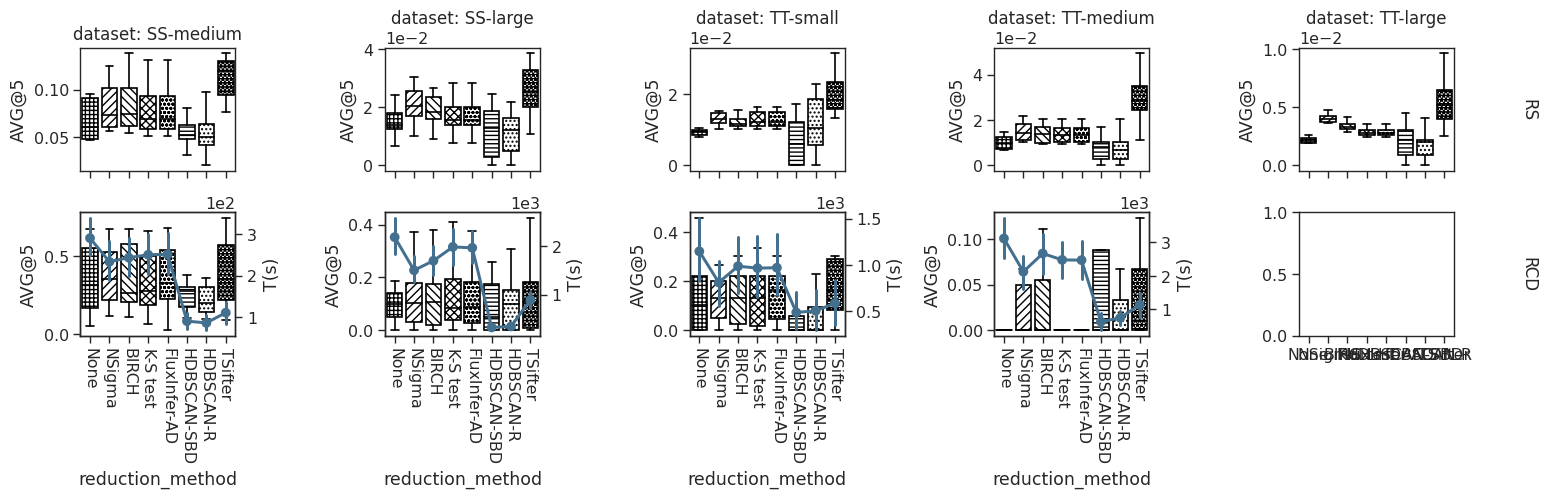

In [408]:
# remove localization methods that perform less well than RS

plot_grid(datasets[1:], loc_methods=["RS", "RCD"], col="dataset", row="localization_method")

/tmp/ipykernel_3717222/819793350.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


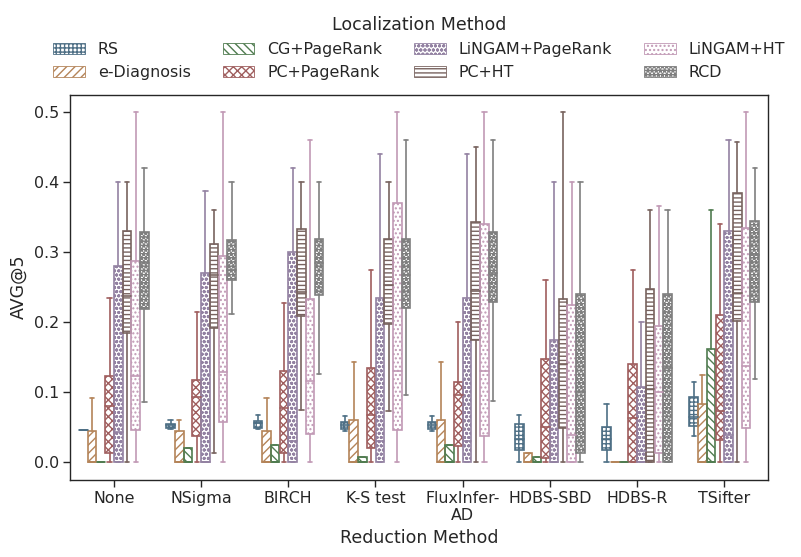

In [397]:
plot_combination("SS-small", "avg@5", "AVG@5", loc_methods=LOC_METHODS)

/tmp/ipykernel_3717222/819793350.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


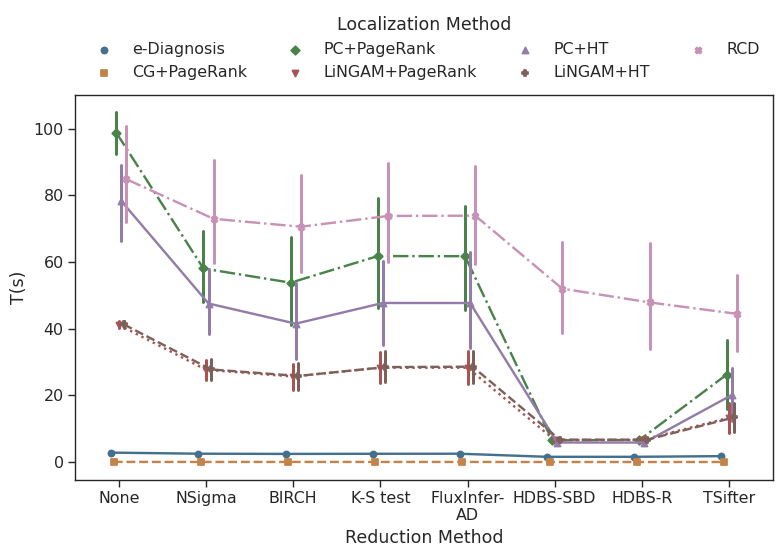

In [398]:
plot_combination("SS-small", "elapsed_time_loc", "T(s)", loc_methods=LOC_METHODS[1:], plot_type="point")

In [261]:
# num_metrics = pd.Series([100, 90, 80])
# num_found_metrics = pd.Series([2, 3, 1])

# def get_scores_of_random_selection(num_metrics: pd.Series, num_found_metrics: pd.Series, max_k: int = 5):

#     def ac_k(num_metrics, num_found_ground_truth, k: int):
#         n, g = num_metrics, num_found_ground_truth
#         prob_single_correct = g / n
#         prob_at_least_one_correct = 1 - (1 - prob_single_correct) ** k
#         return prob_at_least_one_correct.mean()

#     def avg_k(ac_k_) -> dict:
#         return {k: sum([ac_k_[j] for j in range(1, k + 1)]) / k for k in range(1, max_k + 1)}

#     ac_k_ = {k: ac_k(num_metrics, num_found_metrics, k) for k in range(1, max_k + 1)}
#     avg_k_ = avg_k(ac_k_)

#     return {f"AC_{k}": v for k, v in ac_k_.items()}, {f"AVG_{k}": v for k, v in avg_k_.items()}

# get_scores_of_random_selection(num_metrics, num_found_metrics)

## Ablation Study

In [262]:
TSDR_ABLATION_START_ID, TSDR_ABLATION_END_ID = 894, 899
TSDR_ABLATION_RUN_IDS = [f"TSDR-{id}" for id in range(TSDR_ABLATION_START_ID, TSDR_ABLATION_END_ID + 1)]

In [263]:
def convert_to_step_name(phase: str) -> str:
    match phase:
        case "phase1":
            return "STEP0"
        case "phase2":
            return "STEP0-1"
        case "phase3":
            return "STEP0-3"
        case _:
            assert False, f"Unknown phase: {phase}"

def fetch_tsdr_metadata_by_phase(run_id: str) -> list[dict[str, str|float]]:
    with neptune.init_run(
        project="yuuk1/tsdr",
        with_id=run_id,
        capture_stdout=False,
        capture_stderr=False,
        capture_hardware_metrics=False,
        mode="read-only",
    ) as run:
        if run["sys/trashed"] == True:
            return []
        dataset = run["dataset"].fetch()
        target_app = dataset["target_app"]
        middleware = dataset["metric_types"]["middlewares"]
        manually_selected = dataset["use_manually_selected_metrics"]

        tsdr_params = run["parameters"].fetch()
        enable_uni: bool = tsdr_params["enable_unireducer"]
        enable_multi: bool = tsdr_params["enable_multireducer"]
        if uni_method := tsdr_params.get("step1_model_name", False) or tsdr_params.get("step1_method_name", False):
            uni_method = uni_method
        if multi_method := tsdr_params.get("step2_clustering_method_name", False) or tsdr_params.get("step2_dbscan_algorithm", False):
            multi_method = multi_method
        if multi_dist_type := tsdr_params.get("step2_dbscan_dist_type", False):
            multi_dist_type = multi_dist_type
        
        reduction: str
        match (enable_uni, enable_multi, uni_method, multi_method, multi_dist_type):
            case (True, True, "changepoint", "changepoint-kde", _):
                reduction = "TSifter"
            case (_, _, _, _, _):
                return []
                # assert False, f"Unknown reduction method: {tsdr_params}, RUN_ID: {run_id}"

        csv_path = f"/tmp/summary_by_phase-csv-{run_id}.csv"
        run["scores/summary_by_phase-csv"].download(destination=csv_path)
        summary_by_phase = pd.read_csv(csv_path)
        items = []
        for _, row in summary_by_phase.iterrows():  # skip phase1 simple filtering
            num_series = tuple([int(s) for s in row["num_series/total"].split("/")])
            num_found_cause_metrics = row["cause_metrics/num_mandatory_found_mean"]

            frr = row["reduction_rate_mean"]
            rfr = row["cause_metrics/recall_mandatory_mean"]
            rfp = row["cause_metrics/proportion_mandatory_mean"]
            elapsed_time = row["elapsed_time"]

            items.append({
                "dataset": convert_to_dataset_name(target_app, middleware, manually_selected),
                "method": convert_to_step_name(row["phase"]),
                "phase": row["phase"],
                "FRR": frr, "RFR": rfr, "RFP": rfp, "elapsed_time": elapsed_time,
                "num_metrics(reduced)": num_series[0], "num_metrics(filtered)": num_series[1], "num_metrics(raw)": num_series[2], "num_found_cause_metrics": num_found_cause_metrics,
                "rs_ac@2": row["RS_AC_2"], "rs_ac@5": row["RS_AC_5"], "rs_avg@5": row["RS_AVG_5"],
            })
        return items

In [264]:
tsdr_phase_items = joblib.Parallel(n_jobs=32)(joblib.delayed(fetch_tsdr_metadata_by_phase)(run) for run in TSDR_ABLATION_RUN_IDS)
assert tsdr_phase_items is not None
tsdr_phase_items = sum(tsdr_phase_items, [])
tsdr_phase_items = [item for item in tsdr_phase_items if item]

https://app.neptune.ai/yuuk1/tsdr/e/TSDR-896
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-894
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-897
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-899
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-898
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-895
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-896/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-899/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-895/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/yuuk1/tsdr/e/TSDR-898/metadata
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
http

In [400]:
steps = ["STEP0", "STEP0-1", "STEP0-3"]
metrics = ["FRR", "RFR", "RFP", "elapsed_time"]
ss_datasets = ["SS-small", "SS-medium", "SS-large"]
tt_datasets = ["TT-small", "TT-medium", "TT-large"]
datasets = ss_datasets + tt_datasets

multi_level_indexes = pd.MultiIndex.from_product(
    [datasets, steps], names=['Dataset', 'Step'],
)
multi_level_cols = pd.MultiIndex.from_product(
    [datasets, metrics], names=['', ''],
)

tsdr_phase_df = pd.DataFrame(tsdr_phase_items).set_index(['dataset', 'method']).reindex(
    index=multi_level_indexes,
)
tsdr_phase_df["elapsed_time"] = tsdr_phase_df["elapsed_time"].cumsum()

In [402]:
tsdr_phase_df

phase       FRR       RFR       RFP  elapsed_time  \
Dataset   Step                                                          
SS-small  STEP0    phase1  0.000000  1.000000  0.015521      0.276900   
          STEP0-1  phase2  0.213769  0.950000  0.019729      0.520684   
          STEP0-3  phase3  0.379029  0.925000  0.026659      0.747197   
SS-medium STEP0    phase1  0.000000  1.000000  0.023891      1.044536   
          STEP0-1  phase2  0.244541  0.964583  0.031460      1.402977   
          STEP0-3  phase3  0.478974  0.935000  0.046651      1.712011   
SS-large  STEP0    phase1  0.000000  1.000000  0.005023      2.158005   
          STEP0-1  phase2  0.254490  0.963167  0.006453      3.643800   
          STEP0-3  phase3  0.557006  0.851227  0.009771      4.620239   
TT-small  STEP0    phase1  0.000000  1.000000  0.003093      5.430205   
          STEP0-1  phase2  0.433013  0.928571  0.005002      6.349634   
          STEP0-3  phase3  0.603525  0.928571  0.007366      7.260574   
TT-medium STEP0    phase1  0.000000  1.000000  0.003438      8.151165   
          STEP0-1  phase2  0.430388  0.952381  0.005751      9.892629   
          STEP0-3  phase3  0.697163  0.943651  0.010825     11.444415   
TT-large  STEP0    phase1  0.000000  1.000000  0.000727     13.346934   
          STEP0-1  phase2  0.348138  0.976190  0.001092     22.783434   
          STEP0-3  phase3  0.714668  0.786281  0.001993     32.073767   

                   num_metrics(reduced)  num_metrics(filtered)  \
Dataset   Step                                                   
SS-small  STEP0                      64                     64   
          STEP0-1                    50                     64   
          STEP0-3                    40                     64   
SS-medium STEP0                     185                    185   
          STEP0-1                   140                    185   
          STEP0-3                    96                    185   
SS-large  STEP0                    1347                   1347   
          STEP0-1                  1005                   1347   
          STEP0-3                   599                   1347   
TT-small  STEP0                     329                    329   
          STEP0-1                   187                    329   
          STEP0-3                   131                    329   
TT-medium STEP0                    1250                   1250   
          STEP0-1                   714                   1250   
          STEP0-3                   380                   1250   
TT-large  STEP0                    9343                   9343   
          STEP0-1                  6098                   9343   
          STEP0-3                  2677                   9343   

                   num_metrics(raw)  num_found_cause_metrics   rs_ac@2  \
Dataset   Step                                                           
SS-small  STEP0                  80                 1.000000  0.030802   
          STEP0-1                80                 0.950000  0.039017   
          STEP0-3                80                 0.925000  0.052391   
SS-medium STEP0                 499                 4.437500  0.047151   
          STEP0-1               499                 4.225000  0.061740   
          STEP0-3               499                 4.062500  0.090645   
SS-large  STEP0                6793                 6.800000  0.010018   
          STEP0-1              6793                 6.500000  0.012858   
          STEP0-3              6793                 5.600000  0.019424   
TT-small  STEP0                 408                 1.000000  0.006176   
          STEP0-1               408                 0.928571  0.009976   
          STEP0-3               408                 0.928571  0.014668   
TT-medium STEP0                2857                 4.285714  0.006862   
          STEP0-1              2857                 4.142857  0.011464   
          STEP0-3              2857                 4.

In [406]:
import itertools

df_display = tsdr_phase_df[["FRR", "RFR", "RFP", "elapsed_time"]]
tsdr_s = df_display.style
tsdr_s.clear()
# tsdr_s.highlight_max(subset=(itertools.product(datasets, steps), ["FRR", "RFR", "RFP"]), props='textbf:--rwrap;')\
#     .highlight_min(subset=(itertools.product(datasets, steps), ["elapsed_time"]), props='textbf:--rwrap;')
tsdr_s.format({"RFP": '{:.4f}'}, precision=3)
tsdr_s.set_table_styles([
    {'selector': 'toprule', 'props': ':toprule;'},
    {'selector': 'bottomrule', 'props': ':bottomrule;'},
], overwrite=False)

def highlight_max(s, props='textbf:--rwrap;'):
    is_max = s == s.max()
    return [props if v else '' for v in is_max]

def highlight_min(s, props='textbf:--rwrap;'):
    is_min = s == s.min()
    return [props if v else '' for v in is_min]

for dataset in datasets:
    tsdr_s.apply(highlight_max, subset=(itertools.product([dataset], steps), ["FRR", "RFR", "RFP"]), axis=0)
    # tsdr_s.apply(highlight_min, subset=(itertools.product([dataset], steps), ["elapsed_time"]), axis=0)
print(tsdr_s.to_latex(hrules=True))

\begin{tabular}{llrrrr}
\toprule
 &  & FRR & RFR & RFP & elapsed_time \\
Dataset & Step &  &  &  &  \\
\midrule
\multirow[c]{3}{*}{SS-small} & STEP0 & 0.000 & \textbf{1.000} & 0.0155 & 0.277 \\
 & STEP0-1 & 0.214 & 0.950 & 0.0197 & 0.521 \\
 & STEP0-3 & \textbf{0.379} & 0.925 & \textbf{0.0267} & 0.747 \\
\multirow[c]{3}{*}{SS-medium} & STEP0 & 0.000 & \textbf{1.000} & 0.0239 & 1.045 \\
 & STEP0-1 & 0.245 & 0.965 & 0.0315 & 1.403 \\
 & STEP0-3 & \textbf{0.479} & 0.935 & \textbf{0.0467} & 1.712 \\
\multirow[c]{3}{*}{SS-large} & STEP0 & 0.000 & \textbf{1.000} & 0.0050 & 2.158 \\
 & STEP0-1 & 0.254 & 0.963 & 0.0065 & 3.644 \\
 & STEP0-3 & \textbf{0.557} & 0.851 & \textbf{0.0098} & 4.620 \\
\multirow[c]{3}{*}{TT-small} & STEP0 & 0.000 & \textbf{1.000} & 0.0031 & 5.430 \\
 & STEP0-1 & 0.433 & 0.929 & 0.0050 & 6.350 \\
 & STEP0-3 & \textbf{0.604} & 0.929 & \textbf{0.0074} & 7.261 \\
\multirow[c]{3}{*}{TT-medium} & STEP0 & 0.000 & \textbf{1.000} & 0.0034 & 8.151 \\
 & STEP0-1 & 0.430 & 0.952 &

In [404]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    multi_level_indexes = pd.MultiIndex.from_product([ss_datasets, steps], names=['Dataset', 'Step'])
    multi_level_cols = pd.MultiIndex.from_product(
        [ss_datasets, metrics], names=['', ''],
    )
    ss_tsdr_df = pd.DataFrame(tsdr_phase_items).set_index(['dataset', 'method']).reindex(
        index=multi_level_indexes,
    )
    df_pivot = ss_tsdr_df.unstack('Dataset')
    df_pivot = df_pivot.swaplevel(axis=1).sort_index(axis=1).reindex(
        index=steps, columns=multi_level_cols,
    )
    display(df_pivot)

import itertools

df_display = df_pivot[itertools.product(ss_datasets, ["FRR", "RFR", "RFP", "elapsed_time"])].copy()
# df_display.drop(index=["None"], inplace=True)
tsdr_s = df_display.style
tsdr_s.clear()
tsdr_s.highlight_max(subset=(steps, list(itertools.product(ss_datasets, ["FRR", "RFR", "RFP"]))), props='textbf:--rwrap;')\
    .highlight_min(subset=(steps, list(itertools.product(ss_datasets, ["elapsed_time"]))), props='textbf:--rwrap;')
tsdr_s.format({k: '{:.4f}' for k in itertools.product(ss_datasets, ["RFP"])}, precision=3)
print(tsdr_s.to_latex())

SS-small                               SS-medium                      \
              FRR    RFR       RFP elapsed_time       FRR       RFR       RFP   
Step                                                                            
STEP0    0.000000  1.000  0.015521     0.276900  0.000000  1.000000  0.023891   
STEP0-1  0.213769  0.950  0.019729     0.243784  0.244541  0.964583  0.031460   
STEP0-3  0.379029  0.925  0.026659     0.226514  0.478974  0.935000  0.046651   

                      SS-large                                   
        elapsed_time       FRR       RFR       RFP elapsed_time  
Step                                                             
STEP0       0.297339  0.000000  1.000000  0.005023     0.445994  
STEP0-1     0.358441  0.254490  0.963167  0.006453     1.485795  
STEP0-3     0.309034  0.557006  0.851227  0.009771     0.976439

\begin{tabular}{lrrrrrrrrrrrr}
 & \multicolumn{4}{r}{SS-small} & \multicolumn{4}{r}{SS-medium} & \multicolumn{4}{r}{SS-large} \\
 & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time \\
Step &  &  &  &  &  &  &  &  &  &  &  &  \\
STEP0 & 0.000 & \textbf{1.000} & 0.0155 & 0.277 & 0.000 & \textbf{1.000} & 0.0239 & \textbf{0.297} & 0.000 & \textbf{1.000} & 0.0050 & \textbf{0.446} \\
STEP0-1 & 0.214 & 0.950 & 0.0197 & 0.244 & 0.245 & 0.965 & 0.0315 & 0.358 & 0.254 & 0.963 & 0.0065 & 1.486 \\
STEP0-3 & \textbf{0.379} & 0.925 & \textbf{0.0267} & \textbf{0.227} & \textbf{0.479} & 0.935 & \textbf{0.0467} & 0.309 & \textbf{0.557} & 0.851 & \textbf{0.0098} & 0.976 \\
\end{tabular}



In [405]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    multi_level_indexes = pd.MultiIndex.from_product(
        [tt_datasets, steps], names=['Dataset', 'Step'])
    multi_level_cols = pd.MultiIndex.from_product(
        [tt_datasets, metrics], names=['', ''])
    tt_tsdr_df = pd.DataFrame(tsdr_phase_items).set_index(['dataset', 'method']).reindex(
        index=multi_level_indexes)
    display(tt_tsdr_df)
    df_pivot = tt_tsdr_df.unstack('Dataset')
    df_pivot = df_pivot.swaplevel(axis=1).sort_index(axis=1).reindex(
        index=steps, columns=multi_level_cols,
    )
    display(df_pivot)

import itertools

df_display = df_pivot[itertools.product(tt_datasets, ["FRR", "RFR", "RFP", "elapsed_time"])].copy()
# df_display.drop(index=["None"], inplace=True)
tsdr_s = df_display.style
tsdr_s.clear()
tsdr_s.highlight_max(subset=(steps, list(itertools.product(tt_datasets, ["FRR", "RFR", "RFP"]))), props='textbf:--rwrap;')\
    .highlight_min(subset=(steps, list(itertools.product(tt_datasets, ["elapsed_time"]))), props='textbf:--rwrap;')
tsdr_s.format({k: '{:.4f}' for k in itertools.product(tt_datasets, ["RFP"])}, precision=3)
print(tsdr_s.to_latex())

phase       FRR       RFR       RFP  elapsed_time  \
Dataset   Step                                                          
TT-small  STEP0    phase1  0.000000  1.000000  0.003093      0.809967   
          STEP0-1  phase2  0.433013  0.928571  0.005002      0.919429   
          STEP0-3  phase3  0.603525  0.928571  0.007366      0.910940   
TT-medium STEP0    phase1  0.000000  1.000000  0.003438      0.890590   
          STEP0-1  phase2  0.430388  0.952381  0.005751      1.741464   
          STEP0-3  phase3  0.697163  0.943651  0.010825      1.551786   
TT-large  STEP0    phase1  0.000000  1.000000  0.000727      1.902519   
          STEP0-1  phase2  0.348138  0.976190  0.001092      9.436500   
          STEP0-3  phase3  0.714668  0.786281  0.001993      9.290333   

                   num_metrics(reduced)  num_metrics(filtered)  \
Dataset   Step                                                   
TT-small  STEP0                     329                    329   
          STEP0-1                   187                    329   
          STEP0-3                   131                    329   
TT-medium STEP0                    1250                   1250   
          STEP0-1                   714                   1250   
          STEP0-3                   380                   1250   
TT-large  STEP0                    9343                   9343   
          STEP0-1                  6098                   9343   
          STEP0-3                  2677                   9343   

                   num_metrics(raw)  num_found_cause_metrics   rs_ac@2  \
Dataset   Step                                                           
TT-small  STEP0                 408                 1.000000  0.006176   
          STEP0-1               408                 0.928571  0.009976   
          STEP0-3               408                 0.928571  0.014668   
TT-medium STEP0                2857                 4.285714  0.006862   
          STEP0-1              2857                 4.142857  0.011464   
          STEP0-3              2857                 4.095238  0.021519   
TT-large  STEP0               57697                 6.785714  0.001454   
          STEP0-1             57697                 6.642857  0.002184   
          STEP0-3             57697                 5.428571  0.003981   

                    rs_ac@5  rs_avg@5  
Dataset   Step                         
TT-small  STEP0    0.015367  0.009239  
          STEP0-1  0.024733  0.014895  
          STEP0-3  0.036201  0.021845  
TT-medium STEP0    0.017057  0.010260  
          STEP0-1  0.028381  0.017103  
          STEP0-3  0.052832  0.031956  
TT-large  STEP0    0.003632  0.002180  
          STEP0-1  0.005450  0.003272  
          STEP0-3  0.009919  0.005960

TT-small                                  TT-medium            \
              FRR       RFR       RFP elapsed_time       FRR       RFR   
Step                                                                     
STEP0    0.000000  1.000000  0.003093     0.809967  0.000000  1.000000   
STEP0-1  0.433013  0.928571  0.005002     0.919429  0.430388  0.952381   
STEP0-3  0.603525  0.928571  0.007366     0.910940  0.697163  0.943651   

                                TT-large                                   
              RFP elapsed_time       FRR       RFR       RFP elapsed_time  
Step                                                                       
STEP0    0.003438     0.890590  0.000000  1.000000  0.000727     1.902519  
STEP0-1  0.005751     1.741464  0.348138  0.976190  0.001092     9.436500  
STEP0-3  0.010825     1.551786  0.714668  0.786281  0.001993     9.290333

\begin{tabular}{lrrrrrrrrrrrr}
 & \multicolumn{4}{r}{TT-small} & \multicolumn{4}{r}{TT-medium} & \multicolumn{4}{r}{TT-large} \\
 & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time & FRR & RFR & RFP & elapsed_time \\
Step &  &  &  &  &  &  &  &  &  &  &  &  \\
STEP0 & 0.000 & \textbf{1.000} & 0.0031 & \textbf{0.810} & 0.000 & \textbf{1.000} & 0.0034 & \textbf{0.891} & 0.000 & \textbf{1.000} & 0.0007 & \textbf{1.903} \\
STEP0-1 & 0.433 & 0.929 & 0.0050 & 0.919 & 0.430 & 0.952 & 0.0058 & 1.741 & 0.348 & 0.976 & 0.0011 & 9.437 \\
STEP0-3 & \textbf{0.604} & 0.929 & \textbf{0.0074} & 0.911 & \textbf{0.697} & 0.944 & \textbf{0.0108} & 1.552 & \textbf{0.715} & 0.786 & \textbf{0.0020} & 9.290 \\
\end{tabular}

